In [1]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.4 MB/s eta 0:00:00ta 0:00:01


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification , AutoTokenizer,AutoModelForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from torch.utils.data import WeightedRandomSampler
import os
os.environ["WANDB_DISABLED"] = "true"
import warnings
warnings.filterwarnings("default")
import nlpaug.augmenter.word as naw

2025-07-02 07:01:07.025397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751439667.281906      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751439667.361791      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/geopandas/_compat.py:10: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos
/usr/local/lib/python3.11/dist-packages/google/cloud/automl_v1/proto/annotation_payload_pb2.py:277: DeprecationWarning: invalid es

In [3]:
data = pd.read_excel("/kaggle/input/something/AG - AI 2.xlsx")

data["text"] = data["Email Subject"].fillna("") + " " + \
               data["Email Query Discerption"].fillna("") 

In [4]:
data = data.dropna()

In [5]:
owners = list(data['Action Owner'])

In [6]:
data2 = data.drop(["Query Item"],axis=1)
data2

,Email Subject,Email Query Discerption,Query Category,Action Owner,text
0,Subject: RE: Flextronics ----- MaxMega Change ...,"Body: _x000D_\nHi Murthuza,_x000D_\n_x000D_\n ...",Payment related queries,Menaga,Subject: RE: Flextronics ----- MaxMega Change ...
1,Subject: ASRR250505002553 - Reminder - 3 State...,Body: _x000D_\n_x000D_\n _x000D_\n_x000D_\nSu...,Invoice related Queries,Menaga,Subject: ASRR250505002553 - Reminder - 3 State...
2,Subject: Re: Pending invoices for mechanical a...,"Body: _x000D_\nDear Madam, _x000D_\n_x000D_\nP...",Invoice Copies,Menaga,Subject: Re: Pending invoices for mechanical a...
3,Subject: ASRR250505002555 - Reminder - 3 State...,Body: _x000D_\n_x000D_\n _x000D_\n_x000D_\nSu...,Invoice related Queries,Menaga,Subject: ASRR250505002555 - Reminder - 3 State...
4,Subject: ASRR250505002577 - Reminder - 3 State...,Body: _x000D_\n_x000D_\n _x000D_\n_x000D_\nSu...,Invoice related Queries,Menaga,Subject: ASRR250505002577 - Reminder - 3 State...
...,...,...,...,...,...
5433,Subject: RE: OPOR- Week 20 - SP0018826 - Eopto...,Body: _x000D_\nHello @alaia.bi@eoptolink.com <...,Invoice Copies,Md Aquib,Subject: RE: OPOR- Week 20 - SP0018826 - Eopto...
5434,Subject: Re: 230 - SP0002947 - ACTMAX INTERNAT...,"Body: _x000D_\nHi AP,_x000D_\n_x000D_\n _x000D...",Invoice related Queries,Md Aquib,Subject: Re: 230 - SP0002947 - ACTMAX INTERNAT...
5435,Subject: IFX ord conf 1120403468 Your PO J15M7...,Body: _x000D_\n_x000D_\n_x000D_\nDate: 20 May ...,Invoice Copies,Md Aquib,Subject: IFX ord conf 1120403468 Your PO J15M7...
5436,Subject: Invoice PSI-150414,Body: _x000D_\n_x000D_\n_x000D_\nInvoice: PSI-...,Invoice Copies,Md Aquib,Subject: Invoice PSI-150414 Body: _x000D_\n_x0...


In [7]:
import re
import unicodedata
def clean_text(content):
    content = content.replace("_x000D_", "")
    
    content = re.sub(r'http[s]?://\S+', '', content)
    
    content = re.sub(r'This email was sent from someone outside of Flex.*?safe\.', '', content, flags=re.DOTALL)
    
    content = re.sub(r'From:.*?\nSubject:.*?\n', '', content, flags=re.DOTALL)
    content = re.sub(r'From:.*?\nSent:.*?\nTo:.*?\nSubject:.*?\n', '', content, flags=re.DOTALL)
    content = re.sub(r'Thank You.*?\nSincerely.*?\n.*?\n.*?\n', '', content, flags=re.DOTALL)
    
    text = re.sub(r'\n\s*\n', '\n', content).strip()
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"\S+@\S+", "", text)  # remove emails
    text = re.sub(r"\n+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

data2["text"] = data2["text"].apply(clean_text)

In [8]:
data2["Query Category"] = data2["Query Category"].str.strip()

In [9]:
teacher_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
teacher_model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=21)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a837e0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a83310>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a831c0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a83380>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a82d60>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a82cf0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a82dd0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a82b30>
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
mapping = {
    "CN/DN": "CN/DN",
    "cn/DN": "CN/DN",
    "invoice related queries": "Invoice Related Queries",
    "payments": "Payments",
    "PAYMENTS": "Payments",
    "Payments": "Payments",
    "EDI": "EDI",
    "edi": "EDI",
}

data2["Query Category"] = data2["Query Category"].replace(mapping)

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data2["Query Category"] = le.fit_transform(data2["Query Category"])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


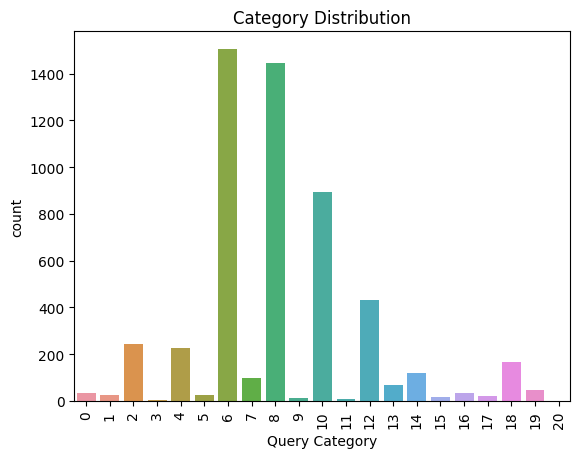

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=data2["Query Category"])
plt.xticks(rotation=90)
plt.title("Category Distribution")
plt.show()

In [13]:
import nlpaug.augmenter.word as naw
import pandas as pd
from collections import Counter

augmenter = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute", device='cuda' if torch.cuda.is_available() else 'cpu'
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e65979eaba0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a830e0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a83700>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e6597a83c40>


In [14]:
label_counts = data2["Query Category"].value_counts()
max_count = label_counts.max()

print(label_counts)

Query Category
6     1505
8     1447
10     895
12     431
2      243
4      225
18     168
14     120
7       97
13      68
19      48
16      36
0       36
5       26
1       25
17      23
15      15
9       14
11       8
3        5
20       2
Name: count, dtype: int64


In [ ]:
from tqdm import tqdm

augmented_texts = []
augmented_labels = []

for label, count in label_counts.items():
    if count < max_count:
        texts = data2[data2["Query Category"] == label]["text"].tolist()
        needed = max_count - count

        # Repeat text until we have enough to augment
        repeats = needed // len(texts) + 1
        texts_to_augment = (texts * repeats)[:needed]

        print(f"Augmenting class '{label}' with {needed} samples...")
        for text in tqdm(texts_to_augment, desc=f"Augmenting '{label}'", leave=False):
            try:
                aug_text = augmenter.augment(text)
                augmented_texts.append(aug_text if isinstance(aug_text, str) else aug_text[0])
                augmented_labels.append(label)
            except Exception as e:
                print(f"Error augmenting: {text} → {e}")


Augmenting class '8' with 58 samples...


Augmenting '8':   5%|▌         | 3/58 [00:35<10:51, 11.85s/it]

In [ ]:
aug_data = pd.DataFrame({"text": augmented_texts, "Query Category": augmented_labels})
data2 = pd.concat([data2, aug_data]).reset_index(drop=True)

print(data2["Query Category"].value_counts())

In [ ]:
data2.to_csv("/kaggle/working/aug_df.csv")

In [ ]:
texts = list(data2["text"])
categorys = list(data2["Query Category"])
true_labels = list(data2["Query Category"].unique())
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    categorys,
    test_size=0.2,
    random_state=42,
    stratify=categorys
)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)
        return item

In [ ]:
train_dataset = TextDataset(train_texts, train_labels, teacher_tokenizer)
val_dataset = TextDataset(val_texts, val_labels, teacher_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from tqdm import tqdm

teacher_model.train()
optimizer = AdamW(teacher_model.parameters(), lr=5e-5, weight_decay=0.0005)

scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.001, patience=1, verbose=True, min_lr=1e-50
)

early_stopping = EarlyStopping(patience=10, min_delta=0.0001)

for epoch in range(10):
    total_loss = 0
    all_preds = []
    all_labels = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(loss=loss.item())

    train_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)

    teacher_model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    teacher_model.train()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

student_tokenizer = BertTokenizer.from_pretrained("distilbert-base-cased")
student_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-cased", num_labels=21
).to(device)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)
student_model.to(device)

teacher_model.eval()
optimizer = AdamW(student_model.parameters(), lr=5e-5,weight_decay=0.0005)

In [ ]:
train_dataset = TextDataset(train_texts, train_labels, student_tokenizer)
val_dataset = TextDataset(val_texts, val_labels, student_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
import torch.nn.functional as F


def distillation_loss(student_logits, teacher_logits, true_labels, temperature=4.0, alpha=0.5):
    # Soft targets
    KD_loss = nn.KLDivLoss(reduction="batchmean")(
        F.log_softmax(student_logits / temperature, dim=1),
        F.softmax(teacher_logits / temperature, dim=1)
    ) * (temperature ** 2)

    # Hard labels
    CE_loss = F.cross_entropy(student_logits, true_labels)

    return alpha * KD_loss + (1 - alpha) * CE_loss


In [ ]:
num_epochs = 10
teacher_model.eval()
for epoch in range(num_epochs):
    student_model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
            teacher_logits = teacher_outputs.logits

        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        student_logits = student_outputs.logits

        loss = distillation_loss(student_logits, teacher_logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(student_logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_accuracy = 100 * correct / total
    print(f"\nEpoch {epoch+1}/{num_epochs} | Train Loss: {total_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")

    student_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
    with torch.no_grad():
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = F.cross_entropy(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_loop.set_postfix(val_loss=loss.item())

    val_accuracy = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%\n")


In [ ]:
def evaluate(model, data_loader, device, desc="Evaluation"):
    model.eval()
    model.to(device)
    total_correct = 0
    total_samples = 0
    total_loss = 0

    loop = tqdm(data_loader, desc=desc)
    with torch.no_grad():
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100 * total_correct / total_samples)

    accuracy = 100 * total_correct / total_samples
    avg_loss = total_loss / len(data_loader)
    return accuracy, avg_loss


train_dataset = TextDataset(train_texts, train_labels, teacher_tokenizer)
val_dataset = TextDataset(val_texts, val_labels, teacher_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

teacher_acc, teacher_loss = evaluate(teacher_model, val_loader, device)

print(f"Final Teacher Accuracy: {teacher_acc:.2f}% | Loss: {teacher_loss:.4f}")


train_dataset = TextDataset(train_texts, train_labels, student_tokenizer)
val_dataset = TextDataset(val_texts, val_labels, student_tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

student_acc, student_loss = evaluate(student_model, val_loader, device)
print(f"Final Student Accuracy: {student_acc:.2f}% | Loss: {student_loss:.4f}")

In [ ]:
student_model.save_pretrained("/kaggle/working/model")